#### Outline
- for each dataset: 
    - load dataset; 
    - for each network: 
        - load network
        - project training data
        - project testing data
        - train KNN classifier (k=1)
        - save results to dataframe

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


In [3]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [4]:
from tfumap.umap import tfUMAP
import tensorflow as tf
from sklearn.decomposition import PCA
from openTSNE import TSNE

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from tqdm.autonotebook import tqdm

In [6]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [7]:
output_dir = MODEL_DIR/'projections' 

In [8]:
KNN_results_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', '1NN_acc', '5NN_acc'])

### MNIST

In [9]:
dataset = 'mnist'
dims = (28,28,1)

##### load dataset

In [10]:
from tensorflow.keras.datasets import mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


#### Network 

##### 2 dims

In [54]:
load_loc = output_dir / dataset / 'network' 

In [55]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    batch_size = 100,
    dims = dims
)

In [56]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [57]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

In [58]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

0.9614

In [59]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

In [60]:
import matplotlib.pyplot as plt

In [29]:
KNN_results_df.loc[len(KNN_results_df)] = ['network', 2, dataset, score_1nn, score_5nn]

In [30]:
KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,mnist,0.9402,0.9614


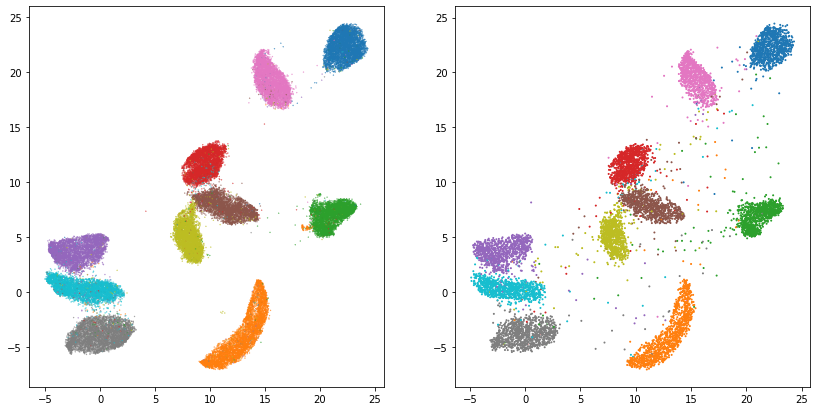

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
axs[0].scatter(Z_train[:,0], Z_train[:,1], c= Y_train, s = 0.1, cmap = plt.cm.tab10)
axs[1].scatter(Z_test[:,0], Z_test[:,1], c= Y_test, s = 1, cmap = plt.cm.tab10)

##### 64 dims

In [32]:
load_loc = output_dir / dataset /"64"/ 'network' 

In [33]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    batch_size = 100,
    dims = dims
)

In [34]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [44]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['network', 64, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,mnist,0.9402,0.9614
1,network,64,mnist,0.9402,0.9614
2,network,64,mnist,0.9518,0.9680
3,autoencoder,2,mnist,0.9403,0.9537
4,autoencoder,64,mnist,0.9481,0.9654
5,network,64,mnist,0.9481,0.9654


### AE 

##### 2 dims

In [36]:
load_loc = output_dir / dataset / 'autoencoder' 

In [37]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [38]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [39]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['autoencoder', 2, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,mnist,0.9402,0.9614
1,network,64,mnist,0.9402,0.9614
2,network,64,mnist,0.9518,0.9680
3,autoencoder,2,mnist,0.9403,0.9537


##### 64 dims

In [40]:
load_loc = output_dir / dataset /"64"/ 'autoencoder' 

In [41]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [42]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [43]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['autoencoder', 64, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,mnist,0.9402,0.9614
1,network,64,mnist,0.9402,0.9614
2,network,64,mnist,0.9518,0.9680
3,autoencoder,2,mnist,0.9403,0.9537
4,autoencoder,64,mnist,0.9481,0.9654


#### UMAP-learn

##### 2 dims

In [35]:
embedder = UMAP(n_components = 2, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Jul 15 18:01:39 2020 Finding Nearest Neighbors
Wed Jul 15 18:01:39 2020 Building RP forest with 16 trees
Wed Jul 15 18:01:40 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Wed Jul 15 18:01:50 2020 Finished Nearest Neighbor Search
Wed Jul 15 18:01:53 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jul 15 18:02:22 2020 Finished embedding


In [36]:
n_repeats = 10
times = []
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    embedder.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    times.append(end_time - start_time)
    projection_speeds.loc[len(projection_speeds)] = ['umap-learn', 2, dataset, end_time - start_time]


	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  18.5131106141489
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  6.171556948218495
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  6.02508582896553
	completed  0  /  100

In [37]:
out

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/autoencoder/z_test.npy')

In [38]:
z = embedder.transform(X_test_flat);
out = MODEL_DIR/'projections' / dataset / 'umap-learn' / 'z_test.npy'
ensure_dir(out)
np.save(out, z)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


##### 64 dims

In [39]:
embedder = UMAP(n_components = 64, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=64, verbose=True)
Construct fuzzy simplicial set
Wed Jul 15 18:03:42 2020 Finding Nearest Neighbors
Wed Jul 15 18:03:42 2020 Building RP forest with 16 trees
Wed Jul 15 18:03:43 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Wed Jul 15 18:03:45 2020 Finished Nearest Neighbor Search
Wed Jul 15 18:03:45 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jul 15 18:04:25 2020 Finished embedding


In [40]:
n_repeats = 10
times = []
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    embedder.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    projection_speeds.loc[len(projection_speeds)] = ['umap-learn', 64, dataset, end_time - start_time]


	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  7.737278979970142
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  6.599300683941692
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  6.2257287059910595
	completed  0  /  

In [41]:
z = embedder.transform(X_test_flat);
out = MODEL_DIR/'projections' / dataset / '64' / 'umap-learn' / 'z_test.npy'
ensure_dir(out)
np.save(out, z)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


#### PCA

##### 2 dims

In [42]:
pca = PCA(n_components=2)
z = pca.fit_transform(X_train_flat)

In [43]:
n_repeats = 10
times = []
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    times.append(end_time - start_time)
    projection_speeds.loc[len(projection_speeds)] = ['pca', 2, dataset, end_time - start_time]


seconds:  0.013190010795369744
seconds:  0.015808935975655913
seconds:  0.016276339069008827
seconds:  0.01672554202377796
seconds:  0.01585381804034114
seconds:  0.015773904975503683
seconds:  0.021101474994793534
seconds:  0.015751914121210575
seconds:  0.016976549057289958
seconds:  0.01575657492503524



In [44]:
z = pca.transform(X_test_flat);
out = MODEL_DIR/'projections' / dataset / 'PCA' / 'z_test.npy'
ensure_dir(out)
np.save(out, z)

##### 64 dims

In [45]:
pca = PCA(n_components=64)
z = pca.fit_transform(X_train_flat)

In [46]:
n_repeats = 10
times = []
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    times.append(end_time - start_time)
    projection_speeds.loc[len(projection_speeds)] = ['pca', 64, dataset, end_time - start_time]


seconds:  0.01728856796398759
seconds:  0.019113640068098903
seconds:  0.01961219310760498
seconds:  0.024873132118955255
seconds:  0.0210996950045228
seconds:  0.019199062138795853
seconds:  0.01913468004204333
seconds:  0.01969355600886047
seconds:  0.020082728005945683
seconds:  0.02104313299059868



In [47]:
z = pca.transform(X_test_flat);
out = MODEL_DIR/'projections' / dataset / "64" / 'PCA'  / 'z_test.npy'
ensure_dir(out)
np.save(out, z)

#### TSNE

##### 2 dims

In [48]:
tsne = TSNE(
    n_components = 2,
    n_jobs=32,
    verbose=True
)

In [49]:
embedding_train = tsne.fit(X_train_flat)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, neighbors=None, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


   --> Time elapsed: 38.30 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.42 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.46 seconds
===> Running optimization with exaggeration=12.00, lr=4166.67 for 250 iterations...
Iteration   50, KL divergence 6.3489, 50 iterations in 1.7019 sec
Iteration  100, KL divergence 5.8474, 50 iterations in 1.6989 sec
Iteration  150, KL divergence 5.7250, 50 iterations in 1.6605 sec
Iteration  200, KL divergence 5.6724, 50 iterations in 1.6305 sec
Iteration  250, KL divergence 5.6437, 50 iterations in 1.6128 sec
   --> Time elapsed: 8.31 seconds
===> Running optimization with exaggeration=1.00, lr=4166.67 for 500 iterations...
Iteration   50, KL divergence 4.0645, 50 iterations in 1.5667 sec
Iteration  100, KL divergence 3.5600, 50 iterations in 1.5632 sec
Iteration  150, KL divergence 3.3039, 50 iterations in 2.0804 sec
Iteration  200, KL divergence 3.1388, 50 iterations in 2.9397 sec
Iteration  250, KL di

In [50]:
n_repeats = 10
times = []
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    embedding_train.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    times.append(end_time - start_time)
    projection_speeds.loc[len(projection_speeds)] = ['TSNE', 2, dataset, end_time - start_time]

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 4.25 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 200952.3360, 50 iterations in 0.2759 sec
Iteration  100, KL divergence 201079.6128, 50 iterations in 0.2745 sec
Iteration  150, KL divergence 201167.5801, 50 iterations in 0.2623 sec
Iteration  200, KL divergence 201234.9335, 50 iterations in 0.2841 sec
Iteration  250, KL divergence 201287.4537, 50 iterations in 0.2761 sec
   --> Time elapsed: 1.37 seconds
seconds:  6.798035054001957
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 4.31 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===

In [51]:
z = embedding_train.transform(X_test_flat);
out = MODEL_DIR/'projections' / dataset / 'TSNE' / 'z_test.npy'
ensure_dir(out)
np.save(out, z)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 4.26 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 200952.3360, 50 iterations in 0.2846 sec
Iteration  100, KL divergence 201079.6128, 50 iterations in 0.2545 sec
Iteration  150, KL divergence 201167.5801, 50 iterations in 0.2946 sec
Iteration  200, KL divergence 201234.9335, 50 iterations in 0.2686 sec
Iteration  250, KL divergence 201287.4537, 50 iterations in 0.2768 sec
   --> Time elapsed: 1.38 seconds


In [52]:
projection_speeds

,method_,dimensions,dataset,speed
0,network,2,mnist,1.758568
1,network,2,mnist,0.287872
2,network,2,mnist,0.275906
3,network,2,mnist,0.296053
4,network,2,mnist,0.295496
...,...,...,...,...
105,TSNE,2,mnist,5.849369
106,TSNE,2,mnist,5.760688
107,TSNE,2,mnist,5.866591
108,TSNE,2,mnist,5.760509


### Save

In [53]:
save_loc = DATA_DIR / 'knn_classifier' / (dataset + '.pickle')
ensure_dir(save_loc)
projection_speeds.to_pickle(save_loc)